In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorboard
import torch as th
from scipy import stats

from copy import deepcopy

from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
import stable_baselines3

from stochastic.processes.continuous import BrownianMotion, GeometricBrownianMotion, BesselProcess, BrownianBridge, BrownianMeander
from stochastic.processes.diffusion import ConstantElasticityVarianceProcess

import sys
sys.path.append("../") # <-- Path to the main repo

from main.agents.Agent import Agent
from main.agents.AvellanedaStoikovAgent import AvellanedaStoikovAgent
from main.agents.BaselineAgents import RandomAgent, FixedSpreadAgent
from main.agents.SBAgent import SBAgent
from main.gym.ModelBasedEnvironment import ModelBasedEnvironment
from main.gym.models import *
from main.gym.wrappers import *
from main.gym.AvellanedaStoikovEnvironment import AvellanedaStoikovEnvironment
from main.gym.helpers.generate_trajectory import generate_trajectory
from main.rewards.RewardFunctions import PnL#InventoryAdjustedPnL
from main.gym.helpers.plotting import plot_stable_baselines_actions

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Learning Inventory-neutral behaviour with SAC

In [9]:
# Add a linearly decreasing learning rate function
def linear_schedule(initial_value):
    def func(progress):
        return progress * initial_value

    return func
schedule = linear_schedule(0.00003) # Here, we use the default SB value

In [4]:
tensorboard_logdir = "./tensorboard/SAC-learning-AS-pnl/"
best_model_path = "./SB_models/PPO-best-PnL"

In [5]:
terminal_time = 1.0
n_steps = 1000
arrival_rate = 50.0
timestamps = np.linspace(0, terminal_time, n_steps + 1)
env_params = dict(terminal_time=terminal_time, n_steps=n_steps, arrival_rate=arrival_rate)
as_env = AvellanedaStoikovEnvironment(**env_params)
reduced_env = ReduceStateSizeWrapper(as_env)

n_envs = 6
gym.envs.register(id="as-env-v0", entry_point="__main__:AvellanedaStoikovEnvironment", kwargs=env_params)
vec_env = make_vec_env(env_id="as-env-v0", n_envs=n_envs, wrapper_class=ReduceStateSizeWrapper)

In [6]:
policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

In [7]:
sac_params = {"policy":'MlpPolicy', "env": vec_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "batch_size": 2048, "learning_rate": schedule} #256 before (batch size)
callback_params = dict(eval_env=reduced_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

In [10]:
callback = EvalCallback(**callback_params)
model = SAC(**sac_params)

Using cpu device


In [11]:
model.learning_rate = linear_schedule(0.00001*0.01)
#model.batch_size = 256*2

In [12]:
model.learn(total_timesteps = 1_000_000, callback=callback)

Logging to ./tensorboard/SAC-learning-AS-pnl/SAC_17
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 12.9     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 326      |
|    time_elapsed    | 18       |
|    total_timesteps | 6000     |
| train/             |          |
|    actor_loss      | -1.37    |
|    critic_loss     | 1.72     |
|    ent_coef        | 0.997    |
|    ent_coef_loss   | -0.00985 |
|    learning_rate   | 2.98e-06 |
|    n_updates       | 983      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.7     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 322      |
|    time_elapsed    | 37       |
|    total_timesteps | 12000    |
| train/             |          |
|    actor_loss      | -1.55  

/opt/miniconda3/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=60000, episode_reward=9.17 +/- 4.52
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 9.17     |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -3.43    |
|    critic_loss     | 1.3      |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.0977  |
|    learning_rate   | 2.82e-06 |
|    n_updates       | 9983     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11.1     |
| time/              |          |
|    episodes        | 56       |
|    fps             | 97       |
|    time_elapsed    | 614      |
|    total_timesteps | 60000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    e

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 116      |
|    fps             | 97       |
|    time_elapsed    | 1226     |
|    total_timesteps | 120000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 120      |
|    fps             | 97       |
|    time_elapsed    | 1226     |
|    total_timesteps | 120000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 124      |
|    fps             | 101      |
|    time_elapsed    | 1244     |
|    total_timesteps | 126000   |
| train/      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 184      |
|    fps             | 100      |
|    time_elapsed    | 1854     |
|    total_timesteps | 186000   |
| train/             |          |
|    actor_loss      | -13.4    |
|    critic_loss     | 1.15     |
|    ent_coef        | 0.919    |
|    ent_coef_loss   | -0.274   |
|    learning_rate   | 2.44e-06 |
|    n_updates       | 30983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 188      |
|    fps             | 102      |
|    time_elapsed    | 1872     |
|    total_timesteps | 192000   |
| train/             |          |
|    actor_loss      | -13.7    |
|    critic_loss     | 1.82     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    episodes        | 248      |
|    fps             | 101      |
|    time_elapsed    | 2480     |
|    total_timesteps | 252000   |
| train/             |          |
|    actor_loss      | -21.3    |
|    critic_loss     | 2.85     |
|    ent_coef        | 0.896    |
|    ent_coef_loss   | -0.353   |
|    learning_rate   | 2.24e-06 |
|    n_updates       | 41983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.9     |
| time/              |          |
|    episodes        | 252      |
|    fps             | 101      |
|    time_elapsed    | 2480     |
|    total_timesteps | 252000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.4     |
| time/              |          |
|    episodes        | 312      |
|    fps             | 76       |
|    time_elapsed    | 4069     |
|    total_timesteps | 312000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.5     |
| time/              |          |
|    episodes        | 316      |
|    fps             | 77       |
|    time_elapsed    | 4087     |
|    total_timesteps | 318000   |
| train/             |          |
|    actor_loss      | -30.8    |
|    critic_loss     | 4.81     |
|    ent_coef        | 0.875    |
|    ent_coef_loss   | -0.419   |
|    learning_rate   | 2.05e-06 |
|    n_updates       | 52983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.42     |
| time/              |          |
|    episodes        | 380      |
|    fps             | 81       |
|    time_elapsed    | 4716     |
|    total_timesteps | 384000   |
| train/             |          |
|    actor_loss      | -38.9    |
|    critic_loss     | 4.24     |
|    ent_coef        | 0.856    |
|    ent_coef_loss   | -0.478   |
|    learning_rate   | 1.85e-06 |
|    n_updates       | 63983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.42     |
| time/              |          |
|    episodes        | 384      |
|    fps             | 81       |
|    time_elapsed    | 4716     |
|    total_timesteps | 384000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.7      |
| time/              |          |
|    episodes        | 444      |
|    fps             | 83       |
|    time_elapsed    | 5323     |
|    total_timesteps | 444000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.73     |
| time/              |          |
|    episodes        | 448      |
|    fps             | 84       |
|    time_elapsed    | 5340     |
|    total_timesteps | 450000   |
| train/             |          |
|    actor_loss      | -46.4    |
|    critic_loss     | 4.11     |
|    ent_coef        | 0.84     |
|    ent_coef_loss   | -0.543   |
|    learning_rate   | 1.65e-06 |
|    n_updates       | 74983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.17     |
| time/              |          |
|    episodes        | 512      |
|    fps             | 74       |
|    time_elapsed    | 6899     |
|    total_timesteps | 516000   |
| train/             |          |
|    actor_loss      | -51.1    |
|    critic_loss     | 10.6     |
|    ent_coef        | 0.826    |
|    ent_coef_loss   | -0.594   |
|    learning_rate   | 1.45e-06 |
|    n_updates       | 85983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.17     |
| time/              |          |
|    episodes        | 516      |
|    fps             | 74       |
|    time_elapsed    | 6899     |
|    total_timesteps | 516000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    episodes        | 576      |
|    fps             | 73       |
|    time_elapsed    | 7814     |
|    total_timesteps | 576000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    episodes        | 580      |
|    fps             | 74       |
|    time_elapsed    | 7832     |
|    total_timesteps | 582000   |
| train/             |          |
|    actor_loss      | -53.3    |
|    critic_loss     | 34.1     |
|    ent_coef        | 0.814    |
|    ent_coef_loss   | -0.636   |
|    learning_rate   | 1.25e-06 |
|    n_updates       | 96983    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 644      |
|    fps             | 69       |
|    time_elapsed    | 9329     |
|    total_timesteps | 648000   |
| train/             |          |
|    actor_loss      | -54.9    |
|    critic_loss     | 2.41     |
|    ent_coef        | 0.803    |
|    ent_coef_loss   | -0.682   |
|    learning_rate   | 1.06e-06 |
|    n_updates       | 107983   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11       |
| time/              |          |
|    episodes        | 648      |
|    fps             | 69       |
|    time_elapsed    | 9329     |
|    total_timesteps | 648000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 11.2     |
| time/              |          |
|    episodes        | 708      |
|    fps             | 71       |
|    time_elapsed    | 9943     |
|    total_timesteps | 708000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 10.8     |
| time/              |          |
|    episodes        | 712      |
|    fps             | 71       |
|    time_elapsed    | 9961     |
|    total_timesteps | 714000   |
| train/             |          |
|    actor_loss      | -56.9    |
|    critic_loss     | 5.94     |
|    ent_coef        | 0.795    |
|    ent_coef_loss   | -0.714   |
|    learning_rate   | 8.58e-07 |
|    n_updates       | 118983   |
---------------------------------
Eval num_timesteps=720000, episode_reward=9.78 +/- 4.70
Episode length: 1000.00 +/

Eval num_timesteps=780000, episode_reward=9.81 +/- 4.69
Episode length: 1000.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 9.81     |
| time/              |          |
|    total_timesteps | 780000   |
| train/             |          |
|    actor_loss      | -57.6    |
|    critic_loss     | 5.37     |
|    ent_coef        | 0.788    |
|    ent_coef_loss   | -0.743   |
|    learning_rate   | 6.6e-07  |
|    n_updates       | 129983   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.86     |
| time/              |          |
|    episodes        | 776      |
|    fps             | 70       |
|    time_elapsed    | 11020    |
|    total_timesteps | 780000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+0

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.62     |
| time/              |          |
|    episodes        | 836      |
|    fps             | 72       |
|    time_elapsed    | 11631    |
|    total_timesteps | 840000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.62     |
| time/              |          |
|    episodes        | 840      |
|    fps             | 72       |
|    time_elapsed    | 11631    |
|    total_timesteps | 840000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.71     |
| time/              |          |
|    episodes        | 844      |
|    fps             | 72       |
|    time_elapsed    | 11649    |
|    total_timesteps | 846000   |
| train/      

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.28     |
| time/              |          |
|    episodes        | 904      |
|    fps             | 73       |
|    time_elapsed    | 12265    |
|    total_timesteps | 906000   |
| train/             |          |
|    actor_loss      | -56.9    |
|    critic_loss     | 3.24     |
|    ent_coef        | 0.781    |
|    ent_coef_loss   | -0.774   |
|    learning_rate   | 2.82e-07 |
|    n_updates       | 150983   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.02     |
| time/              |          |
|    episodes        | 908      |
|    fps             | 74       |
|    time_elapsed    | 12283    |
|    total_timesteps | 912000   |
| train/             |          |
|    actor_loss      | -58.4    |
|    critic_loss     | 24.8     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.78     |
| time/              |          |
|    episodes        | 968      |
|    fps             | 75       |
|    time_elapsed    | 12895    |
|    total_timesteps | 972000   |
| train/             |          |
|    actor_loss      | -57.1    |
|    critic_loss     | 3.94     |
|    ent_coef        | 0.779    |
|    ent_coef_loss   | -0.79    |
|    learning_rate   | 8.4e-08  |
|    n_updates       | 161983   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 9.78     |
| time/              |          |
|    episodes        | 972      |
|    fps             | 75       |
|    time_elapsed    | 12895    |
|    total_timesteps | 972000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_me

### Plotting the agent's action against their inventory

In [14]:
best_model = SAC.load(best_model_path+"/best_model")

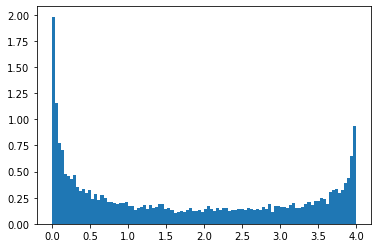

In [21]:
actions = np.array([best_model.predict([0,0.5])[0][0] for _ in range(10000)])
plt.hist(actions, bins = 100, density=True)
plt.show()

In [16]:
inventories = [-3,-2,-1,0,1,2,3]
[best_model.predict([inventory,0. ], deterministic=True)[0] for inventory in inventories]

[array([2.269475 , 1.8344071], dtype=float32),
 array([2.2321534, 2.0293202], dtype=float32),
 array([1.830793 , 2.2071128], dtype=float32),
 array([1.5734482, 2.3069947], dtype=float32),
 array([1.8166066, 1.9171448], dtype=float32),
 array([1.9229681, 1.8013668], dtype=float32),
 array([1.9112322, 1.7903938], dtype=float32)]

In [17]:
print(f"Mean action: {np.median(actions)}, Median action: {np.mean(actions)}")

Mean action: 1.447717547416687, Median action: 1.744773030281067


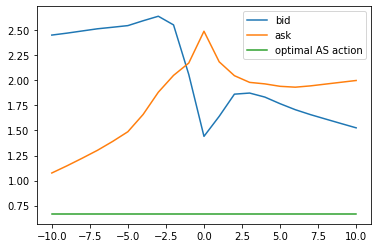

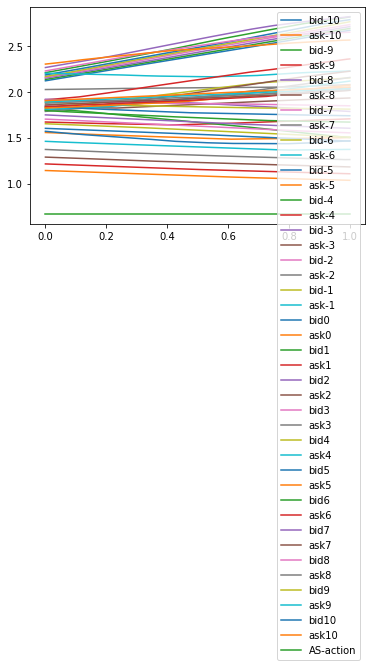

In [18]:
best_model = SAC.load(best_model_path+"/best_model")
#best_model = model
inventories = np.arange(-10,11,1)#[-3,-2,-1,0,1,2,3]
as_agent = AvellanedaStoikovAgent(risk_aversion=0)
as_actions = np.array([as_agent.get_action([100,0,inventory,0.0]) for inventory in inventories])
actions = np.array([best_model.predict([inventory,0.6 ], deterministic=True)[0] for inventory in inventories])
plt.plot(inventories, actions[:,0], label="bid")
plt.plot(inventories, actions[:,1], label="ask")
plt.plot(inventories, as_actions[:,0], label="optimal AS action")
plt.legend()
plt.show()
actions = {}
for inventory in inventories:
    actions[inventory] = np.array([best_model.predict([inventory,ts], deterministic=True)[0] for ts in timestamps])    
    plt.plot(timestamps, actions[inventory][:,0], label = "bid"+str(inventory))
    plt.plot(timestamps, actions[inventory][:,1], label = "ask"+str(inventory))
as_actions = np.array([as_agent.get_action([0,0,0,0]) for ts in timestamps])
plt.plot(timestamps, as_actions[:,0], label="AS-action")
plt.legend()
plt.show()

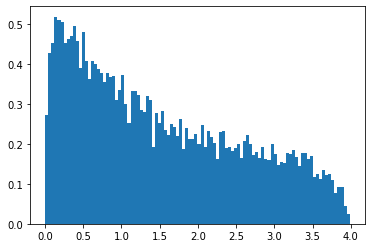

In [19]:
actions = np.array([best_model.predict([inventory,3])[0][0] for _ in range(10000)])
plt.hist(actions, bins = 100, density=True)
plt.show()